# Multilayer Perceptron

In [2]:
from data.train_data import log_train_df
from tqdm.auto import tqdm
from model.mlp.utils import compute_rdkit_descriptors
import pandas as pd

descriptors = [compute_rdkit_descriptors(s) for s in tqdm(log_train_df['SMILES'])]
desc_df = pd.DataFrame(descriptors)
log_train_df = log_train_df.merge(desc_df, on='SMILES')
log_train_df

100%|██████████| 5326/5326 [00:37<00:00, 143.09it/s]


,SMILES,Molecule Name,LogD,LogS,Log_HLM_CLint,Log_MLM_CLint,Log_Caco_Papp_AB,Log_Caco_ER,Log_Mouse_PPB,Log_Mouse_BPB,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,CN1CCC[C@H]1COc1ccc(-c2nc3cc(-c4ccc5[nH]c(-c6c...,E-0001321,NaN,NaN,1.758912,2.263162,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,COc1ccc2c(c1)c1cc3cnccc3c(C)c1n2C,E-0001780,NaN,NaN,2.207904,3.131009,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,Cc1c2ccncc2cc2c3cc(OCCCN4CCN(C)CC4)ccc3n(C)c12,E-0001827,NaN,NaN,NaN,2.288920,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,CN(C)CCCOc1ccc(-c2nc3cc(NC(=O)c4ccc5[nH]c(-c6c...,E-0002019,NaN,NaN,1.021189,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,CN(C)CCCOc1ccc2nc(-c3ccc(-c4nc5ccc(OCCCN(C)C)c...,E-0002036,NaN,NaN,NaN,2.212188,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5321,CCn1c(C(=O)N2CCN(c3ccncc3)CC2)cc2cc(-c3nnc(C4C...,E-0020096,2.5,-3.588380,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
5322,Cc1nnc(-c2cnc3c(c2)cc(C(=O)N2CCCN(c4ccncc4C)CC...,E-0020097,1.5,-3.555955,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
5323,Cc1nnc(-c2ccc3c(c2)cc(C(=O)N2CCCN(c4ccncc4)CC2...,E-0020098,1.0,-3.562249,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
5324,Cc1nnc(-c2ccc3c(c2)cc(C(=O)N2CCCN(c4ccncc4C)CC...,E-0020099,2.2,-3.562249,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [9]:
import numpy as np
from data.train_data import log_col_names
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
import warnings

drop_columns = ['SMILES', 'Molecule Name']
drop_columns.extend(log_col_names)

result_list = []

for col in tqdm(log_col_names):

    tmp_df = log_train_df.query(f"{col}.notnull()").copy()
    for i in tqdm(range(0, 10)):
        train, test = train_test_split(tmp_df)

        y_train = np.array(train[col])
        X_train = train.drop(columns=drop_columns).to_numpy()

        model = XGBRegressor(n_estimators=500,learning_rate=0.05,max_depth=6,subsample=0.8)

        model.fit(X_train, y_train)

        y_test = np.array(test[col])
        X_test = test.drop(columns=drop_columns).to_numpy()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", UserWarning)
            y_pred = model.predict(X_test)
        
        r2 = r2_score(y_test, y_pred)

        result_list.append([col, len(train), len(test), r2])




100%|██████████| 9/9 [03:00<00:00, 20.04s/it]


In [10]:
result_df = pd.DataFrame(result_list, columns=["Assay", "Num_Train", "Num_Test", "R2"])
result_df

,Assay,Num_Train,Num_Test,R2
0,LogD,3779,1260,0.851793
1,LogD,3779,1260,0.860240
2,LogD,3779,1260,0.845252
3,LogD,3779,1260,0.864466
4,LogD,3779,1260,0.863313
...,...,...,...,...
85,Log_Mouse_MPB,166,56,0.620076
86,Log_Mouse_MPB,166,56,0.681929
87,Log_Mouse_MPB,166,56,0.732076
88,Log_Mouse_MPB,166,56,0.555451


/var/folders/3q/k60j09d564qcc9h5p068mfp40000gn/T/ipykernel_18103/4263322429.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["\n".join(x.split("_")) for x in labels])


[Text(0, 0, 'LogD'),
 Text(1, 0, 'LogS'),
 Text(2, 0, 'Log\nHLM\nCLint'),
 Text(3, 0, 'Log\nMLM\nCLint'),
 Text(4, 0, 'Log\nCaco\nPapp\nAB'),
 Text(5, 0, 'Log\nCaco\nER'),
 Text(6, 0, 'Log\nMouse\nPPB'),
 Text(7, 0, 'Log\nMouse\nBPB'),
 Text(8, 0, 'Log\nMouse\nMPB')]

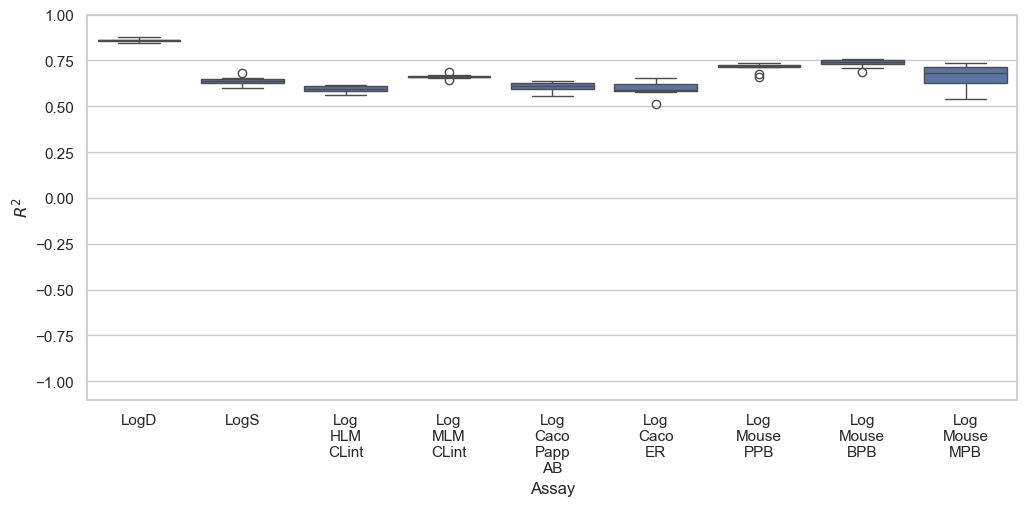

In [12]:
import seaborn as sns
sns.set(rc={"figure.figsize": (12, 5)})
sns.set(style="whitegrid")
ax = sns.boxplot(x="Assay", y="R2", data=result_df)
ax.set_ylim(-1.1, 1)
ax.set_ylabel("$R^2$")
labels = [x.get_text() for x in ax.get_xticklabels()]
ax.set_xticklabels(["\n".join(x.split("_")) for x in labels])